# An old FiPy solution to 1D BL
I'm not really sure if the result is correct.
The results is indeed incorrect. See the updated code a few cells below that might work slightly better.

In [123]:
# import packages and define the functions
import relative_permeability as relperm
import fractional_flow as ff
from fipy import *
import numpy as np
import matplotlib.pyplot as plt

In [124]:
# define parameters
u = 1.e-3
L = 100.
nx = 200
dx = L/nx
muo = 0.002
muw = 0.001
p0 = 100e5
k=1e-12
phi=0.3

swc = 0.1
sor = 0.15
krw0 = 0.3
kro0 = 1.0
nw = 2.0
no = 2.0

kro = lambda sw: relperm.kro(sw, kro0, sor, swc, no)
krw = lambda sw: relperm.krw(sw, krw0, sor, swc, nw)
dkrw = lambda sw: relperm.dkrwdsw(sw, krw0, sor, swc, nw)
dkro = lambda sw: relperm.dkrodsw(sw, kro0, sor, swc, no)

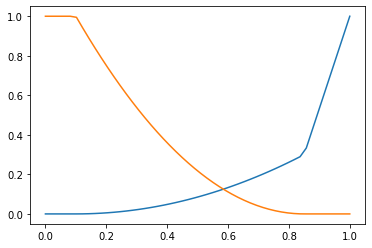

In [125]:
# plot the rel-perms
sw_plot = np.linspace(0, 1, 50)
krw_plot = [krw(sw) for sw in sw_plot]
kro_plot = [kro(sw) for sw in sw_plot]

plt.figure(1)
plt.plot(sw_plot, krw_plot, sw_plot, kro_plot)


In [126]:
# define the mesh and variables
mesh = Grid1D(dx = L/nx, nx = nx)
x = mesh.cellCenters

# create the cell variables and boundary conditions
sw = CellVariable(mesh=mesh, name="saturation", hasOld=True, value = swc)
p = CellVariable(mesh=mesh, name="pressure", hasOld=True, value = p0)


In [127]:
# Boundary conditions
sw.constrain(1.0, mesh.facesLeft)
#sw.constrain(0., mesh.facesRight)
sw.faceGrad.constrain([0], mesh.facesRight)
p.constrain(p0, mesh.facesRight)
p.constrain(1.1*p0, mesh.facesLeft)
# p.faceGrad.constrain([-u/(krw(1-sor)*k/muw)], mesh.facesLeft)

In [128]:
# define the equations
eq_p = DiffusionTerm(var=p, coeff=-k*(krw(sw.faceValue)/muw+kro(sw.faceValue)/muo))- \
UpwindConvectionTerm(var=sw, coeff=-k*(dkrw(sw.faceValue)/muw+dkro(sw.faceValue)/muo)*p.faceGrad)- \
(k*(dkrw(sw.faceValue)/muw+dkro(sw.faceValue)/muo)*sw.faceValue*p.faceGrad).divergence == 0

eq_sw = TransientTerm(coeff=phi, var=sw) + \
DiffusionTerm(var=p, coeff=-k*krw(sw.faceValue)/muw)+ \
UpwindConvectionTerm(var=sw, coeff=-k*dkrw(sw.faceValue)/muw*p.faceGrad)- \
(-k*dkrw(sw.faceValue)/muw*p.faceGrad*sw.faceValue).divergence == 0

error is pressure 0.00400 and saturation 0.00001
error is pressure 0.00000 and saturation 0.00000
error is pressure 0.00000 and saturation 0.00000
error is pressure 0.00001 and saturation 0.00001
error is pressure 0.00001 and saturation 0.00001
error is pressure 0.00000 and saturation 0.00001
error is pressure 0.00000 and saturation 0.00001
error is pressure 0.00001 and saturation 0.00001
error is pressure 0.00001 and saturation 0.00001
error is pressure 0.00001 and saturation 0.00000
error is pressure 0.00000 and saturation 0.00000
error is pressure 0.00000 and saturation 0.00000
error is pressure 0.00000 and saturation 0.00001
error is pressure 0.00000 and saturation 0.00001
error is pressure 0.00000 and saturation 0.00001
error is pressure 0.00001 and saturation 0.00001
error is pressure 0.00001 and saturation 0.00000
error is pressure 0.00000 and saturation 0.00000
error is pressure 0.00000 and saturation 0.00000
error is pressure 0.00000 and saturation 0.00001
error is pressure 0.

error is pressure 0.00000 and saturation 0.00000
error is pressure 0.00000 and saturation 0.00000
error is pressure 0.00000 and saturation 0.00000
error is pressure 0.00000 and saturation 0.00000
error is pressure 0.00000 and saturation 0.00000
error is pressure 0.00000 and saturation 0.00000
error is pressure 0.00000 and saturation 0.00000
error is pressure 0.00000 and saturation 0.00000
error is pressure 0.00000 and saturation 0.00000
error is pressure 0.00000 and saturation 0.00000
error is pressure 0.00000 and saturation 0.00000
error is pressure 0.00000 and saturation 0.00000
error is pressure 0.00000 and saturation 0.00000
error is pressure 0.00000 and saturation 0.00000
error is pressure 0.00000 and saturation 0.00000
error is pressure 0.00000 and saturation 0.00000
error is pressure 0.00000 and saturation 0.00000
error is pressure 0.00000 and saturation 0.00000
error is pressure 0.00000 and saturation 0.00000
error is pressure 0.00000 and saturation 0.00000
error is pressure 0.

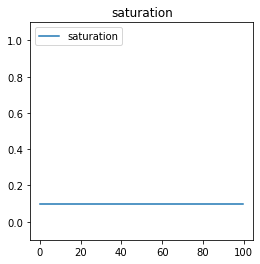

In [129]:
steps = 200
dt = 20000.
viewer = Viewer(vars = sw, datamax=1.1, datamin=-0.1)
for step in range(steps):
    sw.updateOld()
    swres = 1.0e6
    while swres > 1e-5:
        pres=eq_p.sweep(dt = dt, var = p)
        swres=eq_sw.sweep(dt = dt, var = sw)
        print(f'error is pressure {pres:.5f} and saturation {swres:.5f}')
        p.updateOld()
        sw.updateOld()
# viewer.plot()

## Equations
$$\varphi \frac{\partial S_w}{\partial t}+u \frac{\partial f_w}{\partial x}=0$$ or
$$\varphi \frac{\partial S_w}{\partial t}+\nabla.\left( u \frac{\partial f_w}{\partial S_w} S_w\right)+ \nabla. \left( u f_w-u\frac{\partial f_w}{\partial S_w} S_{w0} \right)=0$$

## Analytical solution

In [130]:
xt_shock, sw_shock, xt_prf, sw_prf, t, p_inj, R_oil = ff.frac_flow_wf(muw=muw, muo=muo, ut=u, phi=1.0, \
  k=1e-12, swc=swc, sor=sor, kro0=kro0, no=no, krw0=krw0, \
  nw=nw, sw0=swc, sw_inj=1.0, L=L, pv_inj=5.0)

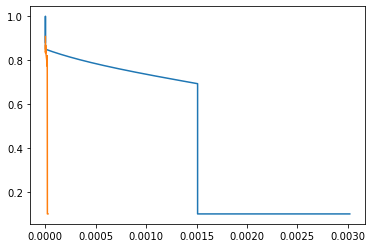

In [131]:
plt.figure()
plt.plot(xt_prf, sw_prf)
plt.plot(x.value.squeeze()/(steps*dt), sw.value)
plt.show()